# Prédiction d'une durée

Ce notebook cherche à prédire la durée de stockage de paquets préparés par un magasin. Chaque paquet met plus ou moins de temps à être préparé. Si la commande arrive le soir et ne peut être finie avant la fin de la journée, elle est reportée sur la journée suivante. C'est la particularité de ce jeu de données.

* L'heure de la commande est uniformément répartie sur la semaine et la journée.
* La durée suit une loi $\Gamma(3, 0.5)$.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Distribution gamma

La loi [Gamma](https://fr.wikipedia.org/wiki/Loi_Gamma) est souvent utilisée pour modéliser une durée de vie.

In [2]:
%matplotlib inline

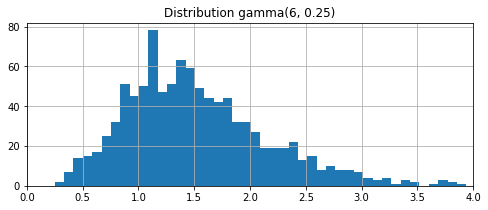

In [3]:
from numpy.random import gamma
g = gamma(6, 0.25, 1000)

import matplotlib.pyplot as plt
import pandas
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df = pandas.DataFrame(dict(g=g, mg=mg))
df.hist('g', bins=50, ax=ax)
ax.set_title('Distribution gamma(6, 0.25)')
ax.set_xlim([0, 4]);

On simule un jeu de données avec la fonction [duration_selling](http://www.xavierdupre.fr/app/papierstat/helpsphinx/papierstat/datasets/duration.html?papierstat.datasets.duration.duration_selling).

In [4]:
from papierstat.datasets import duration_selling
df = duration_selling()
df.head()

,commande,reception,true_duration
0,2018-02-05 10:24:14.624603,2018-02-05 11:42:35.310599,1.305746
1,2018-02-05 10:36:24.190016,2018-02-05 12:09:54.967860,1.558549
2,2018-02-05 09:47:52.839679,2018-02-05 11:48:34.583263,2.011595
3,2018-02-05 15:05:41.000234,2018-02-05 15:43:20.163335,0.627545
4,2018-02-05 12:28:16.760510,2018-02-05 14:17:21.468836,1.817975


In [5]:
df.shape

(2474, 3)

## Quelques statistiques



In [6]:
stat = df.copy()
stat["wk"] = stat.commande.dt.weekday
stat["wk2"] = stat.reception.dt.weekday
stat["hr"] = stat.commande.dt.hour
stat["hr2"] = stat.reception.dt.hour

In [7]:
wk = stat.groupby('wk').count()[["commande"]]
wk2 = stat.groupby('wk2').count()[["reception"]]
wks = wk.merge(wk2, left_on=wk.index, right_on=wk2.index)
wks.columns = ['jour'] + list(wks.columns)[1:]
wks

,jour,commande,reception
0,0,529,525
1,1,474,483
2,2,487,487
3,3,471,485
4,4,513,494


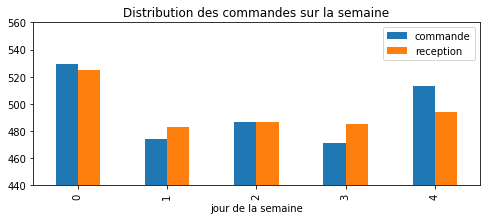

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
wks.plot(x="jour", y=["commande", "reception"], kind="bar", ax=ax)
ax.set_xlabel('jour de la semaine')
ax.set_title("Distribution des commandes sur la semaine")
ax.set_ylim([440,560]);

In [9]:
hr = stat.groupby('hr').count()[["commande"]]
hr2 = stat.groupby('hr2').count()[["reception"]]
hrs = hr.merge(hr2, left_on=hr.index, right_on=hr2.index)
hrs.columns = ['heure'] + list(wks.columns)[1:]
hrs

,heure,commande,reception
0,9,246,253
1,10,281,226
2,11,247,270
3,12,254,256
4,13,253,255
5,14,248,263
6,15,216,238
7,16,239,239
8,17,255,238
9,18,235,236


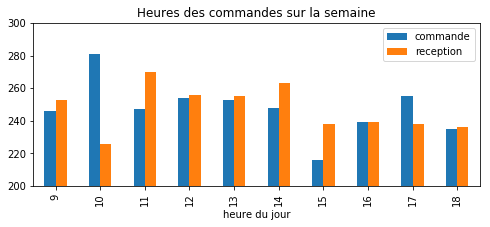

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
hrs.plot(x="heure", y=["commande", "reception"], kind="bar", ax=ax)
ax.set_xlabel('heure du jour')
ax.set_title("Heures des commandes sur la semaine")
ax.set_ylim([200,300]);

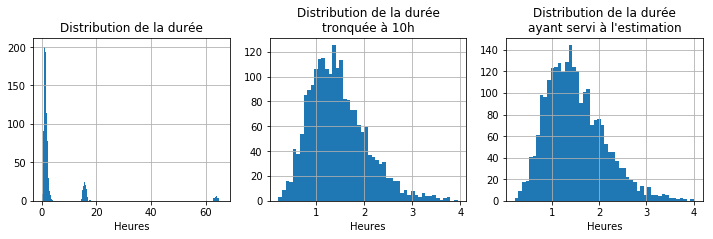

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
stat["duree"] = stat.reception - stat.commande
stat["hours"] = stat.duree.dt.total_seconds() / 3600
stat['hours'].hist(bins=500, ax=ax[0])
stat[stat.seconds < 10]['hours'].hist(bins=50, ax=ax[1])
stat['true_duration'].hist(bins=50, ax=ax[2])
ax[0].set_title("Distribution de la durée")
ax[1].set_title("Distribution de la durée\ntronquée à 10h")
ax[2].set_title("Distribution de la durée\nayant servi à l'estimation")
ax[0].set_xlabel("Heures")
ax[1].set_xlabel("Heures")
ax[2].set_xlabel("Heures");

La distribution montre trois pics : le premier correspond aux paquets réceptionnés dans la journée, le second le lendemain et le troisième le week-end. La durée de livraison dépend uniquement de l'heure d'arrivée de la commande. Si elle arrive assez tôt, la livraison est faite aléatoirement dans la journée, sinon, on passe au jour suivant.

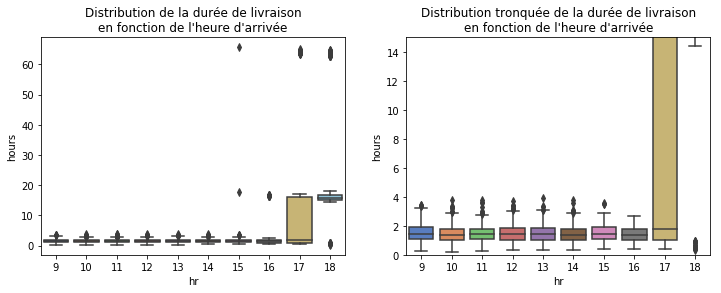

In [12]:
import seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
seaborn.boxplot(x="hr", y="hours", data=stat, palette="muted", ax=ax[0])
seaborn.boxplot(x="hr", y="hours", data=stat, palette="muted", ax=ax[1])
ax[1].set_ylim([0, 15])
ax[0].set_title("Distribution de la durée de livraison\nen fonction de l'heure d'arrivée")
ax[1].set_title("Distribution tronquée de la durée de livraison\nen fonction de l'heure d'arrivée");

## Prédiction de la durée

Il n'y a pas grand-chose à prédire puisque tout est aléatoire excepté le fait que le fait qu'un paquet soit réceptionné le lendemain ou le lundi suivant. On construit donc une variable correspondant à l'heure de commande et le jour de la semaine. On compare un modèle linéaire et un arbre de décision.

### Comparaison d'un modèle linéaire et d'un arbre de précision

In [13]:
data = df.copy()
data["heure"] = data.commande.dt.hour + data.commande.dt.minute / 60
data["wk"] = data.commande.dt.weekday
data['duree'] = (data.reception - data.commande).dt.total_seconds() / 3600
data.head()

,commande,reception,true_duration,heure,wk,duree
0,2018-02-05 10:24:14.624603,2018-02-05 11:42:35.310599,1.305746,10.400000,0,1.305746
1,2018-02-05 10:36:24.190016,2018-02-05 12:09:54.967860,1.558549,10.600000,0,1.558549
2,2018-02-05 09:47:52.839679,2018-02-05 11:48:34.583263,2.011595,9.783333,0,2.011595
3,2018-02-05 15:05:41.000234,2018-02-05 15:43:20.163335,0.627545,15.083333,0,0.627545
4,2018-02-05 12:28:16.760510,2018-02-05 14:17:21.468836,1.817975,12.466667,0,1.817975


In [14]:
X = data[["heure", 'wk']]
y = data["duree"]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)
clr.score(X_test, y_test)

0.23456489208885356

In [17]:
from sklearn.tree import DecisionTreeRegressor
clr2 = DecisionTreeRegressor(max_depth=3)
clr2.fit(X_train, y_train)
clr2.score(X_test, y_test)

0.7385389626451893

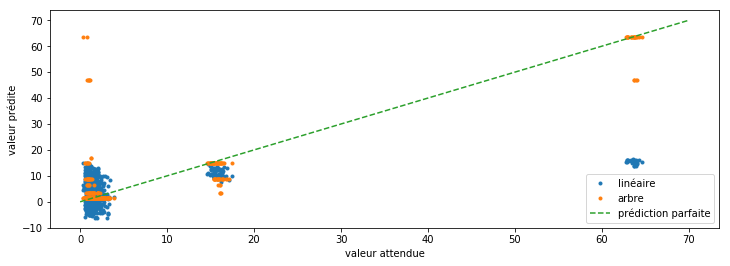

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(y_test, clr.predict(X_test), '.', label="linéaire")
ax.plot(y_test, clr2.predict(X_test), '.', label="arbre")
ax.plot([0,70], [0,70], '--', label="prédiction parfaite")
ax.set_xlabel("valeur attendue")
ax.set_ylabel("valeur prédite")
ax.legend();

L'arbre de décision est nettement meilleur simplement parce que la relation entre la valeur à prédire et les variables n'est pas linéaire.

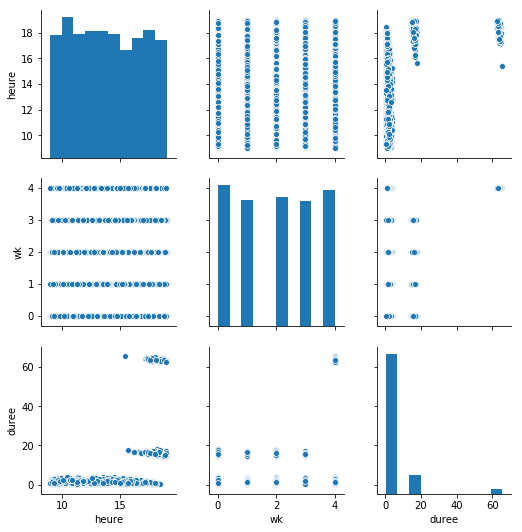

In [19]:
from seaborn import pairplot
xy = X.copy()
xy['duree'] = y
pairplot(xy);

In [20]:
from sklearn.tree import export_graphviz
dot = export_graphviz(clr2, out_file=None, feature_names=X.columns)
from jyquickhelper import RenderJsDot
RenderJsDot(dot)

On voit bien que l'arbre de décision sépare le début et la fin de la journée. Après 17h30, la durée est augmentée de 8h en moyenne, si c'est vendredi, la durée est augmentée d'une vingtaine d'heure. Un modèle linéaire ne peut pas prendre cela en compte.

### Remarque sur le score R2

On voit que le score de prédiction $R^2$ est nettement meilleur pour l'arbre de décision mais c'est un petit peu en trompe l'oeil. La durée de la période d'inactivité joue un rôle non négligeable. Plus elle est longue, plus la durée entre la commande et la réception est grande en moyenne et c'est cette donnée que le modèle linéaire n'arrive pas à prendre en compte.

In [21]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import numpy
res = []
for end in tqdm(range(1, 25)):
    scores_tree = []
    scores_lin = []
    for i in range(0, 5):
        df = duration_selling(hour_end=end, hour_begin=0, week_pattern=[1] * 7)
        data = df.copy()
        data["heure"] = data.commande.dt.hour + data.commande.dt.minute / 60
        data["wk"] = data.commande.dt.weekday
        data['duree'] = (data.reception - data.commande).dt.total_seconds() / 3600    
        X = data[["heure", 'wk']]
        y = data["duree"]
        clr = LinearRegression()
        clr2 = DecisionTreeRegressor(max_depth=3)
        score_tree = cross_val_score(clr2, X, y, cv=5).mean()
        score_lin = cross_val_score(clr, X, y, cv=5).mean()
        scores_tree.append(score_tree)
        scores_lin.append(score_lin)
    res.append(dict(end=end, score_tree=numpy.array(scores_tree).mean(),
                   score_lin=numpy.array(scores_lin).mean()))
res = pandas.DataFrame(res)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:13<00:00,  1.81it/s]


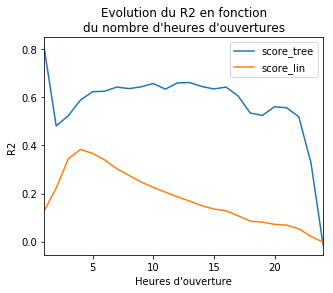

In [22]:
ax = res.plot(x='end', y=['score_tree', 'score_lin'], figsize=(5,4))
ax.set_title("Evolution du R2 en fonction\ndu nombre d'heures d'ouvertures")
ax.set_xlabel("Heures d'ouverture")
ax.set_ylabel("R2");

On voit que le $R^2$ pour l'arbre de décision et le modèle tendent vers 0 lorsque le nombre d'heures d'ouverture tend vers 24, cela signifie qu'il n'y a plus d'effets de seuil : la durée entre la réception et la commande suit une loi gamma et est complètement aléatoire. C'est attendu. A l'opposé, lorsque le nombre d'heures d'ouverture est très faible, la durée entre la commande et la réception est quasiment un mulitple de 24h puisque le magasin n'est quasiment jamais ouvert : l'arbre de décision est nettement meilleur dans ce cas. Le pic de $R^2$ est obtenu vers 4-5h d'ouvertures, cela correspond au moment où il y a au pire une seule nuit entre la réception et la commande.

Pour ce problème, le coefficient $R^2$ ne paraît pas être la bonne solution puisque de toute façon, le modèle prédit simplement si le paquet sera réceptionné le jour même ou le suivant. Ce serait plutôt un problème de classification binaire.